# Particle Localization

We build a neural network to determine the position of microscopic particles within an image.

## Load Data

We use a dataset including two videos of optically trapped particles.

In [1]:
import os

if not os.path.exists("particle_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/particle_dataset")

We define the `load_video` function to load the videos, save it in `fnc_particle_localization.py` ...

```python
def load_video(path, frames_to_load=100, image_size=51):
    video = cv2.VideoCapture(path)
    data = []
    for _ in range(frames_to_load):
        (_, frame) = video.read()
        frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255
        frame = cv2.resize(frame, (image_size, image_size))
        data.append(frame)
    return np.array(data)
```

... and use it to read the data.

In [2]:
def load_video(path, frames_to_load=100, image_size=51):
    import cv2
    import numpy as np

    video = cv2.VideoCapture(path)

    data = []
    for _ in range(frames_to_load):
        (_, frame) = video.read()
        frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255
        frame = cv2.resize(frame, (image_size, image_size))
        data.append(frame)

    return np.array(data)

In [3]:
#from fnc_particle_localization import load_video

video_low_noise = load_video(os.path.join("particle_dataset", "high_noise.avi"))
video_high_noise = load_video(os.path.join("particle_dataset", "low_noise.avi"))

We plot the first 5 frames of each video.

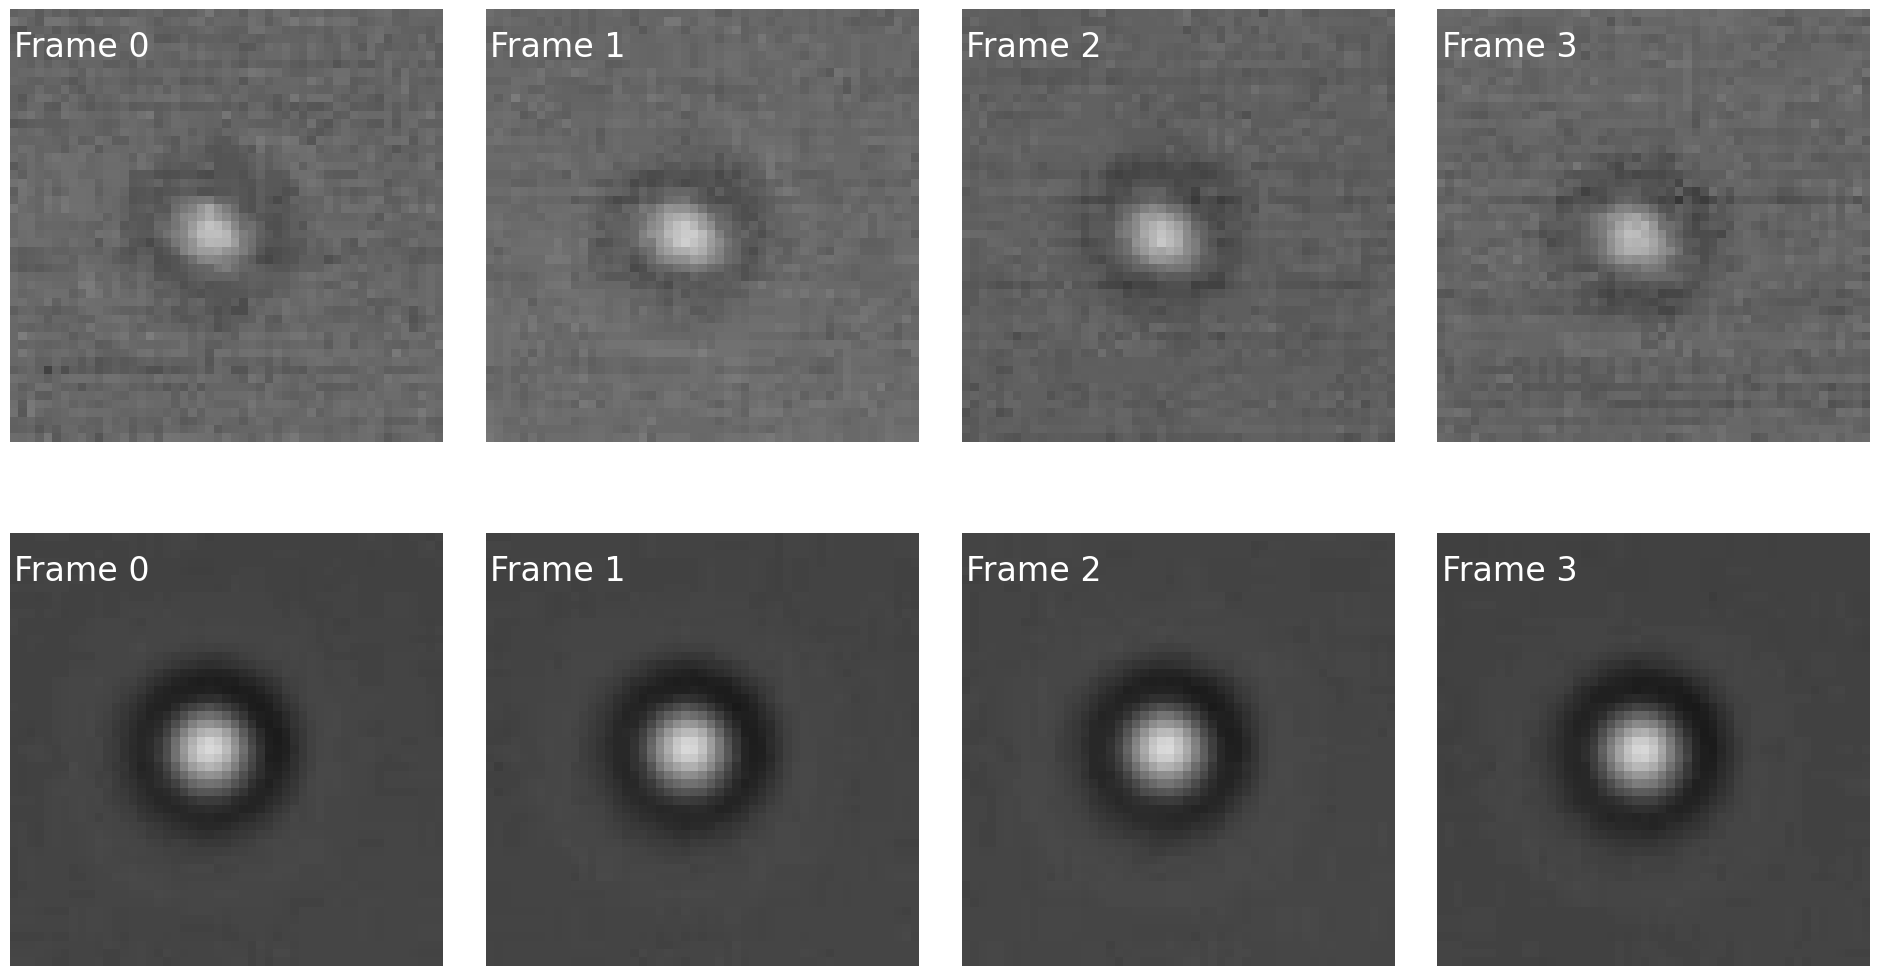

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4, figsize=(24, 13))
for i in range(4):
    axs[0, i].imshow(video_low_noise[i], cmap="gray", vmin=0, vmax=1)
    axs[0, i].text(0, 5, f"Frame {i}", color="white", fontsize=24)
    axs[0, i].axis("off")
    
    axs[1, i].imshow(video_high_noise[i], cmap="gray", vmin=0, vmax=1)
    axs[1, i].text(0, 5, f"Frame {i}", color="white", fontsize=24)
    axs[1, i].axis("off")

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## Annotate Data Manually

We define a class to be able to interactively select the centroid of particles in some of the video frames.

```python
class ParticleCenter:

    def __init__(self, images):
        self.images = images
        self.positions = []
        self.i = 0
        self.fig, self.ax = plt.subplots(1, 1, figsize=(5, 5))
        self.fig.canvas.header_visible = False
        self.fig.canvas.footer_visible = False

    def start(self):
        self.im = self.ax.imshow(self.images[self.i], cmap="gray", vmin=0, vmax=1)
        self.text = self.ax.text(
            3,
            5,
            "Frame " + str(self.i + 1) + " of " + str(len(self.images)),
            color="white",
            fontsize=12,
        )
        self.ax.axis("off")
        self.cursor = Cursor(self.ax, useblit=True, color="red", linewidth=1)
        self.cid = self.fig.canvas.mpl_connect("button_press_event", self.onclick)
        self.next_image()
        plt.show()

    def next_image(self):
        im = self.images[self.i]
        self.im.set_data(im)
        self.text.set_text("Frame " + str(self.i + 1) + " of " + str(len(self.images)))
        self.fig.canvas.draw_idle()

    def onclick(self, event):
        self.positions.append([event.xdata, event.ydata])
        if self.i < len(self.images) - 1:
            self.i += 1
            self.next_image()
        else:
            self.fig.canvas.mpl_disconnect(self.cid)
            plt.close()
            return
```

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor

class ManualAnnotation:
    def __init__(self, images):
        self.images = images
        self.positions = []
        self.i = 0
        self.fig, self.ax = plt.subplots(1, 1, figsize=(5, 5))
        self.fig.canvas.header_visible = False
        self.fig.canvas.footer_visible = False

    def start(self):
        self.im = self.ax.imshow(self.images[self.i], cmap="gray", vmin=0, vmax=1)
        self.text = self.ax.text(
            3, 
            5, 
            f"Frame {self.i + 1} of {len(self.images)}", 
            color="white", 
            fontsize=12,
        )
        self.ax.axis("off")
        self.cursor = Cursor(self.ax, useblit=True, color="red", linewidth=1)
        self.cid = self.fig.canvas.mpl_connect("button_press_event", self.onclick)
        self.next_image()
        plt.show()

    def next_image(self):
        self.im.set_data(self.images[self.i])
        self.text.set_text(f"Frame {self.i + 1} of {len(self.images)}")
        self.fig.canvas.draw_idle()

    def onclick(self, event):
        self.positions.append([event.xdata, event.ydata])
        if self.i < len(self.images) - 1:
            self.i += 1
            self.next_image()
        else:
            self.fig.canvas.mpl_disconnect(self.cid)
            plt.close()
            return

We randomly select `number_of_images_to_annotate` frames and ask you to manually pinpoint the particle center.

In [ ]:
%matplotlib ipympl 
# Needed for using the interactive features of matplotlib in Notebooks

import numpy as np
#from fnc_particle_localization import ManualAnnotation

number_of_images_to_annotate = 100

dataset = np.concatenate([video_low_noise, video_high_noise], axis=0)
np.random.shuffle(dataset)

images_to_annotate = np.random.choice(
  np.arange(dataset.shape[0]),
  number_of_images_to_annotate,
  replace=False,
)

manual_annotation = ManualAnnotation(dataset[images_to_annotate])

manual_annotation.start()

annotated_images = manual_annotation.images
manual_positions = manual_annotation.positions

# Back to normal matplotlib backend
%matplotlib inline

We save the annotated images and the corresponding centroid positions in two files.

In [7]:
file_images = os.path.join("particle_dataset", "annotated_images.npy")
#np.save(file_images, np.array(annotated_images))

file_positions = os.path.join("particle_dataset", "manual_positions.npy")
#np.save(file_positions, np.array(manual_positions))

## Preprocess Dataset

We use the annotated data to train and test a CNN. First, we define a `Dataset` class to provide the data in the needed format.

```python
class ParticleDataset(Dataset):
    import torch
    import numpy as np

    def __init__(self, file, dir):
        self.im = np.load(os.path.join(dir, file))
        name, ext = os.path.splitext(file)
        self.pos = np.load(os.path.join(dir, name + "_labels" + ext))

    def __len__(self):
        return self.im.shape[0]

    def __getitem__(self, idx):
        img = torch.tensor(self.im[idx, np.newaxis, :, :]).float()
        labels = torch.tensor(self.pos[idx] / self.im.shape[1] - 0.5).float()
        sample = [img, labels]
        return sample
```
The `ParticleDataset` class reads the annotated data, transform the images into torch tensors and rescales the centroid positions in [-1.1].

In [5]:
import numpy as np
import torch
from torch.utils.data import Dataset

class ParticleDataset(Dataset):
    def __init__(self, file_images, file_positions):
        self.images = np.load(file_images)
        self.positions = np.load(file_positions)

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        im = torch.tensor(self.images[idx, np.newaxis, :, :]).float()
        pos = torch.tensor(self.positions[idx] / im.shape[-1] - .5).float()
        sample = [im, pos]
        return sample


In [8]:
#from fnc_particle_localization import ParticleDataset

dataset = ParticleDataset(file_images, file_positions)

We split the annotated data and define two data loaders.

In [9]:
import deeplay as dl
from torch.utils.data import random_split

train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

train_dataloader = dl.DataLoader(train_dataset, batch_size=1)
test_dataloader = dl.DataLoader(test_dataset, batch_size=1)

## Convolutional Neural Network

We define a CNN with a dense top to analyze the images using `deeplay`.

In [10]:
import torch.nn as nn
#from fnc_particle_localization import Flatten

cnn = dl.Sequential(
    dl.ConvolutionalNeuralNetwork(
        in_channels=1,
        hidden_channels=[16, 32],
        out_channels=64,
        pool=nn.MaxPool2d(kernel_size=2),
        out_activation=nn.ReLU,
    ),
    dl.Layer(nn.MaxPool2d, kernel_size=2),
    dl.Layer(nn.Flatten),
    dl.MultiLayerPerceptron(
        in_features=6 * 6 * 64,
        hidden_features=[32, 32],
        out_features=2,
        out_activation=nn.Identity,
    ),
)

print(cnn)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (1): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (2): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identit

We then compile the CNN as a regressor.

In [11]:
import torchmetrics as tm

regressor_template = dl.Regressor(
    model=cnn,
    loss=nn.MSELoss(),
    optimizer=dl.Adam(),
    metrics=[tm.MeanAbsoluteError()],
)

CNN_regressor = regressor_template.create()

## Train

We train the CNN regressor...

In [12]:
CNN_trainer = dl.Trainer(max_epochs=50, accelerator="auto")
CNN_trainer.fit(CNN_regressor, train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Missing logger folder: /Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/Ch03_CNN/Project03B_particle_localization/lightning_logs
2023-12-11 18:51:29.990317: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | MSELoss          | 0     
1 | train_metrics | Metr

Training: |          | 0/? [00:00<?, ?it/s]

... and evaluate its performance over the training set. We also calculate the mean absolute error in pixel units.

In [ ]:
test_results = CNN_trainer.test(CNN_regressor, test_ann_dataloader)

IMAGE_SIZE = test_ann_dataset[0][0].shape[1]
print(
    "Mean pixel error: {:.3f} pixels".format(
        test_results[0]["testMeanAbsoluteError_epoch"] * IMAGE_SIZE
    )
)

## Visualization

We compare annotated and predicted particle positions.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

random_idx = np.random.choice(np.arange(len(test_ann_dataset)), 10, replace=False)

for idx, ax in zip(random_idx, axes.flatten()):
    test_pred = CNN_regressor(test_ann_dataset[idx][0].unsqueeze(0))[0].detach()

    ax.imshow(test_ann_dataset[idx][0].detach().numpy().squeeze(), cmap="gray")
    ax.scatter(
        test_pred[0] * IMAGE_SIZE + IMAGE_SIZE / 2,
        test_pred[1] * IMAGE_SIZE + IMAGE_SIZE / 2,
        marker="x",
        c="r",
        s=100,
        label="prediction",
    )
    ax.scatter(
        test_ann_dataset[idx][1][0] * IMAGE_SIZE + IMAGE_SIZE / 2,
        test_ann_dataset[idx][1][1] * IMAGE_SIZE + IMAGE_SIZE / 2,
        marker="+",
        c="g",
        s=100,
        label="annotation",
    )
    ax.set_axis_off()
ax.legend(loc=(0.2, 0.8), framealpha=1)
plt.show()

## Image simulations
We will use the `deeptrack2.0` library to simulate particle images for which the ground truth is known. In these way we avoid the manual annotation and can have more data available for training.

The particle is defined using the deeptrack object `MieSphere`.

In [ ]:
from deeptrack.scatterers import MieSphere

particle = MieSphere(
    position=(25, 25),
    z=0,
    radius=500e-9,
    refractive_index=1.37,
    position_unit="pixel",
)

Then, we specify the optical device to image the particle.

In [ ]:
from deeptrack.optics import Brightfield

brightfield_microscope = Brightfield(
    wavelength=630e-9,
    NA=0.8,
    resolution=1e-6,
    magnification=15,
    refractive_index_medium=1.33,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
)

We create the image of the particle and display it.

In [ ]:
imaged_particle = brightfield_microscope(particle)

fig = plt.figure()
output_image = imaged_particle.resolve()
plt.imshow(np.squeeze(output_image), cmap="gray")
plt.axis("off")
plt.show()

We create particles with random positions arounf the center and display them.

In [ ]:
particle = MieSphere(
    position=lambda: np.random.uniform(IMAGE_SIZE / 2 - 5, IMAGE_SIZE / 2 + 5, 2),
    z=lambda: np.random.uniform(-1, -1),
    radius=lambda: np.random.uniform(500, 600) * 1e-9,
    refractive_index=lambda: np.random.uniform(1.37, 1.42),
    position_unit="pixel",
)
imaged_particle = brightfield_microscope(particle)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    output_image = imaged_particle.update().resolve()
    ax.imshow(np.squeeze(output_image), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

We also add some Poisson noise to make the images more realistic.

In [ ]:
from deeptrack import Poisson

noise = Poisson(
    min_snr=5,
    max_snr=20,
    snr=lambda min_snr, max_snr: min_snr + np.random.rand() * (max_snr - min_snr),
    background=1,
)

noisy_imaged_particle = imaged_particle >> noise

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    output_image = noisy_imaged_particle.update().resolve()
    ax.imshow(np.squeeze(output_image), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

Finally, we create a pipeline that generates noisy particle images and normalize the pixel values. 

In [ ]:
from deeptrack import NormalizeMinMax

normalization = NormalizeMinMax(
    lambda: np.random.rand() * 0.2, lambda: 0.8 + np.random.rand() * 0.2
)
data_pipeline = noisy_imaged_particle >> normalization

We also define a function to exctract the particle centroid position from the image
```python
def get_label(image):
    from numpy import array
    position = array(image.get_property("position"))
    return position
```
We display some images with the corresponding ground truth position.

In [ ]:
from fnc_particle_localization import get_label

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flatten()):
    output_image = data_pipeline.update().resolve()
    ax.imshow(np.squeeze(output_image), cmap="gray")

    particle_position = get_label(output_image)
    ax.scatter(
        particle_position[1],
        particle_position[0],
        s=60,
        facecolors="none",
        edgecolor="g",
        linewidth=4,
    )

    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

We want to use the simulations for the CNN training. Thus, we modify the class `ParticleDataset` to now work with the simulation pipeline, creating the new class `ParticleDatasetSimul`
```python
class ParticleDatasetSimul(Dataset):
    import torch
    import numpy as np

    def __init__(self, pipeline, data_size):
        im = [pipeline.update().resolve() for _ in range(data_size)]
        self.pos = np.array([get_label(image) for image in im])
        self.im = np.array(im).squeeze()

    def __len__(self):
        return self.im.shape[0]

    def __getitem__(self, idx):
        img = torch.tensor(self.im[idx, np.newaxis, :, :]).float()
        labels = torch.tensor(self.pos[idx] / self.im.shape[1] - 0.5).float()
        sample = [img, labels]
        return sample
```
The class can be used with the data loader and passed to the CNN for training.

In [ ]:
from fnc_particle_localization import ParticleDatasetSimul

train_dataloader = dl.DataLoader(
    ParticleDatasetSimul(pipeline=data_pipeline, data_size=1000), batch_size=32
)

CNN_simul_regressor = regressor_template.create()

CNN_simul_trainer = dl.Trainer(
    max_epochs=50,
    accelerator="auto",
)

CNN_simul_trainer.fit(CNN_simul_regressor, train_dataloader)

We check the network performance on a simulated test dataset...

In [ ]:
test_dataloader = dl.DataLoader(
    ParticleDatasetSimul(pipeline=data_pipeline, data_size=100), batch_size=32
)

test_simul_results = CNN_simul_trainer.test(CNN_simul_regressor, test_dataloader)

print(
    "Mean pixel error: {:.3f} pixels".format(
        test_simul_results[0]["testMeanAbsoluteError_epoch"] * IMAGE_SIZE
    )
)

... and plot the predictions versus the ground truth.

In [ ]:
fig, axs = plt.subplots(1, 2)
pred, gt = [], []
for batch in iter(test_dataloader):
    gt.append(batch[1])
    pred.append(CNN_simul_regressor(batch[0]))
gt = torch.cat(gt, dim=0).numpy()
pred = torch.cat(pred, dim=0).detach().numpy()

for i, l in enumerate(["x", "y"]):
    label = gt[:][:, i]
    prediction = pred[:][:, i]
    axs[i].scatter(label, prediction, alpha=0.2)
    axs[i].plot([np.min(label), np.max(label)], [np.min(label), np.max(label)], c="k")
    axs[i].set_xlabel("Prediction")
    axs[i].set_ylabel("Ground truth")
    axs[i].set_xlim([-0.065, 0.065])
    axs[i].set_ylim([-0.065, 0.065])
    axs[i].set_aspect("equal")
    axs[i].set_title("{i}-coordinates".format(i=l))
for ax in fig.get_axes():
    ax.label_outer()

plt.show()

Let's check now the CNN predictions on the annotated test dataset.

In [ ]:
test_ann_results = CNN_simul_trainer.test(CNN_simul_regressor, test_ann_dataloader)

print(
    "Mean pixel error: {:.3f} pixels".format(
        test_ann_results[0]["testMeanAbsoluteError_epoch"] * IMAGE_SIZE
    )
)

Last, we plot the predictions in comparison to the annotations.

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for idx, ax in zip(random_idx, axes.flatten()):
    test_pred = CNN_simul_regressor(test_ann_dataset[idx][0].unsqueeze(0))[0].detach()

    ax.imshow(test_ann_dataset[idx][0].detach().numpy().squeeze(), cmap="gray")
    ax.scatter(
        test_pred[0] * IMAGE_SIZE + IMAGE_SIZE / 2,
        test_pred[1] * IMAGE_SIZE + IMAGE_SIZE / 2,
        marker="x",
        c="r",
        s=100,
        label="prediction",
    )
    ax.scatter(
        test_ann_dataset[idx][1][0] * IMAGE_SIZE + IMAGE_SIZE / 2,
        test_ann_dataset[idx][1][1] * IMAGE_SIZE + IMAGE_SIZE / 2,
        marker="+",
        c="g",
        s=100,
        label="annotation",
    )
    ax.set_axis_off()
ax.legend(loc=(0.2, 0.8), framealpha=1)
plt.show()